https://www.distributedpython.com/2018/09/25/dask-delayed/

Today, we will look at how to implement a Monte Carlo simulation to value an Asian option in a Jupyter notebook; and how to distribute that Monte Carlo simluation across a cluster using Dask. 

## Asian options
An Asian option is an exotic type of financial option contract. The payoff at expiry depends on the average underlying price over some pre-set period of time - different to a plain vanilla option where the payoff depends on the underlying price at expiry (fun fact: they are called Asian options because legend has it that Bankers Trust traded the first option linked to the average price of crude oil in in Tokyo back in 1987).

The payoff of a fixed-strike Asian call option at expiry is defined as: `C(T) = max(0, A(T) - K)`. There is no closed form analytical formula to determine the fair value any time before expiry for this kind of option. But we can determine the fair value by simulating a large number of paths for the underlying asset price and calculate the payout at expiry for each path. The fair value is then the discounted average over all these Monte Carlo simulations.

## Random walk
We assume that the current value of the underlying asset price is composed of the past value and a determinstic upward trend plus an error term defined as a white noise (a normal variable with zero mean and variance one). This is called a random walk with drift. Given a start price s0, a constant drift mu and volatility sigma, we can simulate the price path over days number of days like this:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def random_walk(s0, mu, sigma, days):
    dt = 1/365.
    prices = np.zeros(days)
    shocks = np.zeros(days)
    prices[0] = s0
    for i in range(1, days):
        e = np.random.normal(loc=mu * dt, scale=sigma * np.sqrt(dt))
        prices[i] = prices[i-1] * (1 + e)
    return prices

For any random path, we can now calculate the average price and, given the strike price K, the payoff at expiry:

In [2]:
days = 365 * 4  # days to expiry
s0 = 100  # current underlying price
mu = 0.02  # drift
sigma = 0.2  # volatility
K = 100  # strike price

value_trace = random_walk(s0, mu, sigma, days)

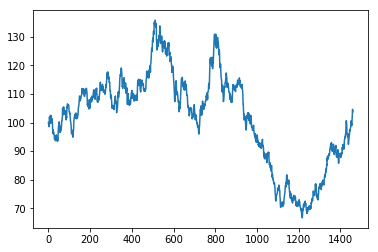

In [3]:
plt.plot(value_trace);

In [4]:
A = np.average(random_walk(s0, mu, sigma, days))
C = max(0, A - K)

print(f"A:{A}, C:{C}")

A:124.9924883622237, C:24.992488362223696


## Monte Carlo Simulation
We need to generate a large number of random price paths for the underlying. For each price path we calculate the associated payoff. These payoffs are averaged and discounted to today. This result is the value of the option. The actual number of simulations n required depends on the confidence level you are comfortable with for the estimate. That, in turn, depends on your option’s parameters. I won’t go into details here, so let’s just assume that n = 10000. We need to generate n random paths and calculate the average value of the option at expiry:

In [5]:
n = 10000
%time np.average([max(0, np.average(random_walk(s0, mu, sigma, days)) - K) for i in range(0, n)])

CPU times: user 40.2 s, sys: 215 ms, total: 40.4 s
Wall time: 40.7 s


11.784090437691411

So the compute taks 40 seconds

## Dask task scheduler: dask.distributed
If you have more than one CPU at your disposal, you can bring down the calculation time by distributing the random walk generation across multiple CPUs. This is where Dask comes in. Dask is a flexible library for parallel computing in Python, optimised for interactive computational workloads. Instead of running n random walks in a single Jupyter notebook process, we make Dask distribute these calculations across a number of processes.

Distributing these calculations is the job of the task scheduler. Think of the task scheduler as a server that manages where and how calculations as executed. There are different types of schedulers: single machine scheduler (limited to local machine) and distributed scheduler (distributed across a cluster). Here, I will use a simple single machine scheduler.

Start a local dask.distributed process scheduler:

In [6]:
from dask.distributed import Client
client = Client(scheduler_port=8786)

In [7]:
client

Client Scheduler: tcp://127.0.0.1:8786 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


## Wrapping functions with dask.delayed
We need to instruct our `random_walk` and `np.average` function calls to execute lazily. Instead of executing the functions immediately, we want to defer execution via the Dask task scheduler. We can achieve this by wrapping functions in dask.delayed. Alternatively, you can decorate your functions with `@dask.delayed` (not covered in this blog post, though have a look at http://dask.pydata.org/en/latest/delayed.html#decorator). This delays the execution of the function and generates a task graph instead.

In [8]:
from dask import delayed

s0 = 100
K = 100
mu = 0.02
sigma = 0.2
days = 365*4
n = 10000

result = delayed(np.average)([
    delayed(max)(
        0, 
        delayed(np.average)(random_walk(s0, mu, sigma, days)) - K
    ) for i in range(0, n)
])

result is now a `Delayed` object and contains the task graph. The task graph is a directed acyclic graph (DAG) and models the dependencies between the `np.average`, `max` and `random_walk` function calls - without executing them. This allows Dask to optimise its task execution strategy.

## Execute the task graph
We have everything in place now to execute the actual calculation of result. Remember that result up to this point is just a Delayed object. Execute the computation:

In [9]:
%time result.compute()

CPU times: user 11.2 s, sys: 891 ms, total: 12.1 s
Wall time: 18 s


11.799691854254482

In essence, the calculation time has roughly halved on 4 cores compared to 1 core. The reason it has not reduced to 25% is that there is some overhead involved in managing and distributing the task themselves. 

## Using decorators

In [11]:
@delayed
def random_walk(s0, mu, sigma, days):
    dt = 1/365.
    prices = np.zeros(days)
    shocks = np.zeros(days)
    prices[0] = s0
    for i in range(1, days):
        e = np.random.normal(loc=mu * dt, scale=sigma * np.sqrt(dt))
        prices[i] = prices[i-1] * (1 + e)
    return prices

@delayed
def daverage(x):
    return np.average(x)

@delayed
def dmax(a, b):
    return max(a, b)

s0 = 100
K = 100
mu = 0.02
sigma = 0.2
days = 365*4
n = 10000

result = daverage([dmax(0, daverage(random_walk(s0, mu, sigma, days)) - K) for i in range(0, n)])

In [12]:
%time result.compute()

CPU times: user 25.8 s, sys: 1.04 s, total: 26.9 s
Wall time: 56.1 s


11.848867826659987

Interesting, time went up

## Pure Numpy
I know the point of this article is to show how to use Dask, but it also shows an example of premature parallelisation--in this case you can get vastly faster results with straight numpy. Here's my implementation:

In [16]:
%%time
dt = 1/365

# Generate an array of normally-distributed random numbers of shape (days - 1, n)
rands = np.random.normal(loc=1 + mu * dt, scale=sigma * np.sqrt(dt), size=(days - 1, n))

# Prepend rands with a row of ones for the first day's price
rands = np.insert(rands, 0, 1, axis=0)

# Value the Asian option along the first axis,
# then take the mean value over the n runs
result = np.average((s0 * np.average(rands.cumprod(axis=0), axis=0) - K).clip(0))

CPU times: user 748 ms, sys: 35 ms, total: 783 ms
Wall time: 756 ms


In [17]:
result

11.75526836503868

Numpy takes less than a second